# WeatherPy
----

##### Dependencies

In [1]:
# import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
from scipy.stats import linregress
from citipy import citipy

# import api keys
from api_keys import weather_api_key

# default strings
output_data_file = "output_data/cities.csv"
weather_url = "https://api.openweathermap.org/data/2.5/weather?q="

# latitude and longitude ranges
lat_range = (-90, 90)
lng_range = (-180, 180)

#### List of cities

In [2]:
# create lists for storing values
lat_lngs = []
cities = []

# randomize lats and lngs
lats = np.random.uniform(low=-90, high=90, size=1500)
lngs = np.random.uniform(low=-180, high=180, size=1500)
lat_lngs = zip(lats, lngs)

# find cities using citipy with lats and lngs
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    if city not in cities:
        cities.append(city)
        
print(f"Number of cities: {len(cities)}")

Number of cities: 583


### Data Retrieval

In [3]:
# create counters for output
record = 1
group = 1

# create list for json data
responses = []

# initial printout
print(f"Beginning Data Retrieval\n"
      f"-----------------------------")

# for loop for api calls for each city
for city in cities:
    
    # create target_url
    target_url = f"{weather_url}{city}&appid={weather_api_key}"
        
    # generate api request and make json
    response = requests.get(target_url).json()
        
    # create a response string
    response_string = str(response)
    
    # city not found
    if response_string == "{'cod': '404', 'message': 'city not found'}":
       
        #print error
        print("City not found. Skipping...")
    
    # city is found
    else:
        
        # print which city is processing
        print(f"Processing Record {record} of Set {group} | {city}")
        responses.append(response)
        
    # count record and set
    if record < 50:
        record += 1
    else:
        record = 1
        group += 1

# final printout
print(f"-----------------------------\n"
      f"Data Retrieval Complete\n"
      f"-----------------------------")

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | bredasdorp
City not found. Skipping...
Processing Record 3 of Set 1 | djambala
Processing Record 4 of Set 1 | chuy
Processing Record 5 of Set 1 | fortuna
Processing Record 6 of Set 1 | castro
Processing Record 7 of Set 1 | homer
Processing Record 8 of Set 1 | makat
Processing Record 9 of Set 1 | east london
Processing Record 10 of Set 1 | dudinka
Processing Record 11 of Set 1 | ponta do sol
Processing Record 12 of Set 1 | tsabong
City not found. Skipping...
Processing Record 14 of Set 1 | lavrentiya
Processing Record 15 of Set 1 | pevek
Processing Record 16 of Set 1 | lebu
Processing Record 17 of Set 1 | ushuaia
Processing Record 18 of Set 1 | esperance
Processing Record 19 of Set 1 | igarka
Processing Record 20 of Set 1 | bambous virieux
Processing Record 21 of Set 1 | vestmannaeyjar
City not found. Skipping...
Processing Record 23 of Set 1 | megion
City not found. Skipping...
Processing Record 25 of

## City Data Frame

In [7]:
# create dictionary for storing datapoints
df = {
    "City": [],
    "Cloudiness": [],
    "Country": [],
    "Date": [],
    "Humidity": [],
    "Lat": [],
    "Lng": [],
    "Max Temp": [],
    "Wind Speed": []
}

# fill out dictionary with data points
for response in range(0, len(responses)):
    df["City"].append(responses[response]['name'])
    df["Cloudiness"].append(responses[response]['clouds']['all'])
    df["Country"].append(responses[response]['sys']['country'])
    df["Date"].append(responses[response]['dt'])
    df["Humidity"].append(responses[response]['main']['humidity'])
    df["Lat"].append(responses[response]['coord']['lat'])
    df["Lng"].append(responses[response]['coord']['lon'])
    df["Max Temp"].append(responses[response]['main']['temp_max'])
    df["Wind Speed"].append(responses[response]['wind']['speed'])
    
# convert dictionary to data frame
city_data = pd.DataFrame(df)

# convert from K to F
city_data["Max Temp"] = round((city_data["Max Temp"] - 273.15) * (9/5) + 32, 2)

# export city_data to CSV
f = city_data.to_csv(output_data_file)

# display the data frame
city_data.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,Bredasdorp,95,ZA,1579583955,82,-34.53,20.04,66.20,7.20
1,Djambala,98,CG,1579583955,90,-2.54,14.75,71.71,1.96
2,Chui,28,UY,1579583955,97,-33.70,-53.46,70.47,2.90
3,Fortuna,90,US,1579583956,62,40.60,-124.16,55.40,8.20
4,Castro,70,BR,1579583956,91,-24.79,-50.01,62.01,2.92


### Latitude vs Temperature Plot

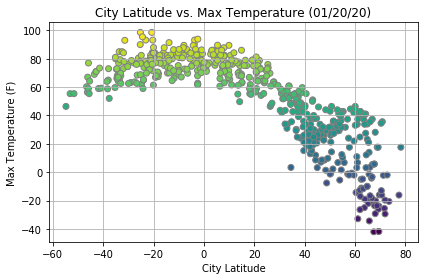

In [8]:
# strings for title and labels
today = "(01/20/20)"
title = f"City Latitude vs. Max Temperature {today}"
xlabel = "City Latitude"
ylabel = "Max Temperature (F)"

# data to plot
x_axis = city_data["Lat"]
y_axis = city_data["Max Temp"]

# plot the data
plt.scatter(x_axis, y_axis, c=y_axis, edgecolors="grey")

# assign title and labels
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# clean up plot
plt.grid(axis='both')
plt.tight_layout()

# display the plot
plt.show()

### Latitude vs Humidity Plot

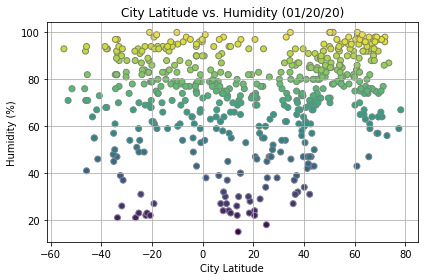

In [9]:
# strings for title and labels
today = "(01/20/20)"
title = f"City Latitude vs. Humidity {today}"
xlabel = "City Latitude"
ylabel = "Humidity (%)"

# data to plot
x_axis = city_data["Lat"]
y_axis = city_data["Humidity"]

# plot the data
plt.scatter(x_axis, y_axis, c=y_axis, edgecolors="grey")

# assign title and labels
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# clean up plot
plt.grid(axis='both')
plt.tight_layout()

# display the plot
plt.show()

### Latitude vs Cloudiness Plot

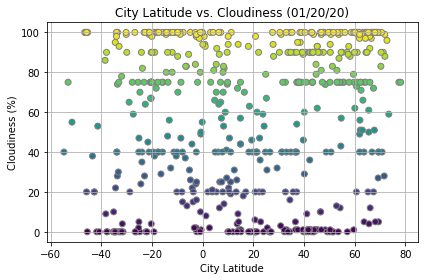

In [10]:
# strings for title and labels
today = "(01/20/20)"
title = f"City Latitude vs. Cloudiness {today}"
xlabel = "City Latitude"
ylabel = "Cloudiness (%)"

# data to plot
x_axis = city_data["Lat"]
y_axis = city_data["Cloudiness"]

# plot the data
plt.scatter(x_axis, y_axis, c=y_axis, edgecolors="grey")

# assign title and labels
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# clean up plot
plt.grid(axis='both')
plt.tight_layout()

# display the plot
plt.show()

### City Latitude vs Wind Speed Plot

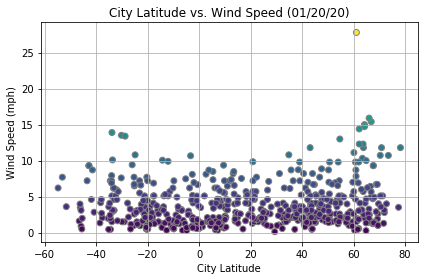

In [11]:
# strings for title and labels
today = "(01/20/20)"
title = f"City Latitude vs. Wind Speed {today}"
xlabel = "City Latitude"
ylabel = "Wind Speed (mph)"

# data to plot
x_axis = city_data["Lat"]
y_axis = city_data["Wind Speed"]

# plot the data
plt.scatter(x_axis, y_axis, c=y_axis, edgecolors="grey")

# assign title and labels
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# clean up plot
plt.grid(axis='both')
plt.tight_layout()

# display the plot
plt.show()

### Regression Analysis

In [12]:
city_data.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,Bredasdorp,95,ZA,1579583955,82,-34.53,20.04,66.20,7.20
1,Djambala,98,CG,1579583955,90,-2.54,14.75,71.71,1.96
2,Chui,28,UY,1579583955,97,-33.70,-53.46,70.47,2.90
3,Fortuna,90,US,1579583956,62,40.60,-124.16,55.40,8.20
4,Castro,70,BR,1579583956,91,-24.79,-50.01,62.01,2.92


In [16]:
# create data frames for each hemisphere
s_hemisphere = city_data.loc[city_data["Lat"] < 0]
n_hemisphere = city_data.loc[city_data["Lat"] > 0]

n_hemisphere

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
3,Fortuna,90,US,1579583956,62,40.60,-124.16,55.40,8.20
5,Homer,1,US,1579583956,92,59.64,-151.55,21.99,1.50
6,Makat,100,KZ,1579583956,92,47.65,53.35,26.08,5.58
8,Dudinka,40,RU,1579583957,64,69.41,86.18,-41.80,1.00
9,Ponta do Sol,75,PT,1579583957,62,32.67,-17.10,57.20,4.10
...,...,...,...,...,...,...,...,...,...
531,Aykhal,92,RU,1579583817,82,66.00,111.50,-16.60,2.00
532,Paamiut,99,GL,1579584110,79,61.99,-49.67,24.80,3.04
533,Bay City,90,US,1579584058,67,43.59,-83.89,24.80,2.10
534,Sahbuz,90,AZ,1579584111,74,39.41,45.57,32.00,3.10


The r-squared value is: 0.741556035852511


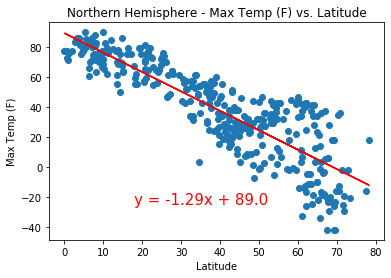

In [38]:
# define independent and dependent variables
hemisphere = "Northern Hemisphere"
independent_variable = "Lat"
dependent_variable = "Max Temp"

# define title and labels
xlabel = "Latitude"
ylabel = "Max Temp (F)"
title = f"{hemisphere} - {ylabel} vs. {xlabel}"

# create dataframe
n_max_temp_v_latitude = n_hemisphere[[independent_variable, dependent_variable]]

# define x and y values
x_values = n_hemisphere[independent_variable]
y_values = n_hemisphere[dependent_variable]

# run regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# calculate regression values and r-squared
regress_values = x_values * slope + intercept
r_squared = rvalue ** 2

# create line equation
line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"

# plot the data
plt.scatter(x_values, y_values)

# plot the regression line
plt.plot(x_values, regress_values, "r-")

# add equation
plt.annotate(line_eq, (18, -25), fontsize=15, color="red")

# add title and labels to plot
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# print summary data
print(f"The r-squared value is: {r_squared}")

# display the plot
plt.show()

The r-squared value is: 0.22699002979471608


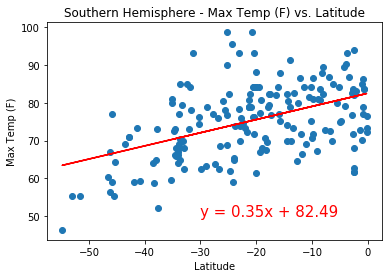

In [41]:
# define independent and dependent variables
hemisphere = "Southern Hemisphere"
independent_variable = "Lat"
dependent_variable = "Max Temp"

# define title and labels
xlabel = "Latitude"
ylabel = "Max Temp (F)"
title = f"{hemisphere} - {ylabel} vs. {xlabel}"

# create dataframe
s_max_temp_v_latitude = s_hemisphere[[independent_variable, dependent_variable]]

# define x and y values
x_values = s_hemisphere[independent_variable]
y_values = s_hemisphere[dependent_variable]

# run regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# calculate regression values and r-squared
regress_values = x_values * slope + intercept
r_squared = rvalue ** 2

# create line equation
line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"

# plot the data
plt.scatter(x_values, y_values)

# plot the regression line
plt.plot(x_values, regress_values, "r-")

# add equation
plt.annotate(line_eq, (-30, 50), fontsize=15, color="red")

# add title and labels to plot
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# print summary data
print(f"The r-squared value is: {r_squared}")

# display the plot
plt.show()

The r-squared value is: 0.13210158634857386


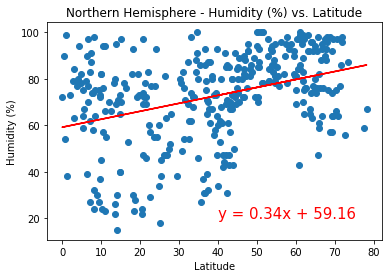

In [43]:
# define independent and dependent variables
hemisphere = "Northern Hemisphere"
independent_variable = "Lat"
dependent_variable = "Humidity"

# define title and labels
xlabel = "Latitude"
ylabel = "Humidity (%)"
title = f"{hemisphere} - {ylabel} vs. {xlabel}"

# create dataframe
n_humidity_v_lat = n_hemisphere[[independent_variable, dependent_variable]]

# define x and y values
x_values = n_hemisphere[independent_variable]
y_values = n_hemisphere[dependent_variable]

# run regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# calculate regression values and r-squared
regress_values = x_values * slope + intercept
r_squared = rvalue ** 2

# create line equation
line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"

# plot the data
plt.scatter(x_values, y_values)

# plot the regression line
plt.plot(x_values, regress_values, "r-")

# add equation
plt.annotate(line_eq, (40, 20), fontsize=15, color="red")

# add title and labels to plot
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

# print summary data
print(f"The r-squared value is: {r_squared}")

# display the plot
plt.show()